# This notebook created for solving Kaggle competition: https://www.kaggle.com/c/roscosmos-rucode/overview

## Data - satellite images in format .tif
## There are some instruments for working with tif format, but rasterio is the easiest to install: https://rasterio.readthedocs.io/en/latest/quickstart.html

### Downloading data and visualisation of test image

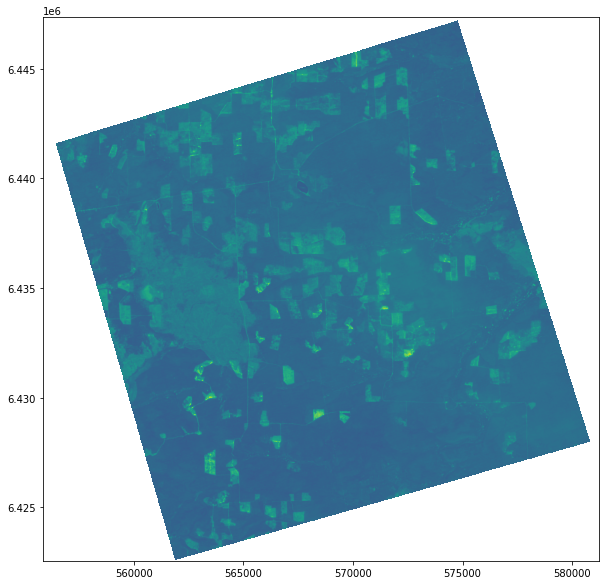

Number of image channels 8


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm
from tqdm import tqdm
import cv2 as cv
import rasterio
from rasterio.plot import show
import scipy as sp
import collections
from skimage.metrics import structural_similarity as ssim
from skimage.data import page
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)
from scipy import stats, optimize, interpolate
import argparse


plt.rcParams["figure.figsize"] = (15,10)


path = '/home/masha/Kaggle/roscosmos-rucode/Images_composit/Images_composit/8_ch/'
input_files = glob.glob(path + '*.tif')

path_masks = '/home/masha/Kaggle/roscosmos-rucode/mask/mask/'
input_masks = glob.glob(path_masks + '*.tif')

ex = r'KV1_20180615_SCN4_UN37__KV3_20200522_SCN4_UN38.tif'


img = rasterio.open(path + ex)
show(img)
print('Number of image channels', img.count) # количество каналов

files_validation = []
masks_validation = []
masks_test = []
files_test = []
for f in input_files:
    name = path_masks + f.split('/')[-1]
    if name in input_masks:
        files_validation.append(f)
        masks_validation.append(name)
    else:
        files_test.append(f)
        masks_test.append(f)

### The first 4 channels are R G B I in the first image and R G B I in the second image

# I chose computer vision unsupervised algorithm SIFT for the backbone of the solution.

## In my decision, I rely on the article where was used approach is based on the SIFT algorithm and an a contrario approach. It can deal with multi-resolutions, multi-sensors and multi-incidence angles situations, and it offers promising results.https://ieeexplore.ieee.org/document/6946667

In [25]:
def bands_array(img):
    """
    img in rasterio format with 8 channels
    
    return array of arrays (each one for one channel)
    """
    
    all_bands = []
    assert img.count == 8
    red_1 = img.read(1)
    all_bands.append(red_1)
    green_1 = img.read(2)
    all_bands.append(green_1)
    blue_1 = img.read(3)
    all_bands.append(blue_1)
    NIR_1 = img.read(4)
    all_bands.append(NIR_1)
    red_2 = img.read(5)
    all_bands.append(red_2)
    green_2 = img.read(6)
    all_bands.append(green_2)
    blue_2 = img.read(7)
    all_bands.append(blue_2)
    NIR_2 = img.read(8)
    all_bands.append(NIR_2)
    all_bands = np.array(all_bands)
    return all_bands


def bands_array_blur(img, n, s):
    """
    img in rasterio format with 8 channels
    
    return array of arrays (each one for one channel)
    with Gaussian Blur
    
    n - size of square (kernel) of Gaussian filter
    s - sigma (dispersion of Gaussian filter)
    """
    
    all_bands = []
    assert img.count == 8
    red_1 = img.read(1).astype(np.float64)
    all_bands.append(cv.GaussianBlur(red_1,(n, n), s))
    green_1 = img.read(2).astype(np.float64)
    all_bands.append(cv.GaussianBlur(green_1,(n, n), s))
    blue_1 = img.read(3).astype(np.float64)
    all_bands.append(cv.GaussianBlur(blue_1,(n, n), s))
    NIR_1 = img.read(4).astype(np.float64)
    all_bands.append(cv.GaussianBlur(NIR_1,(n, n), s))
    red_2 = img.read(5).astype(np.float64)
    all_bands.append(cv.GaussianBlur(red_2,(n, n), s))
    green_2 = img.read(6).astype(np.float64)
    all_bands.append(cv.GaussianBlur(green_2,(n, n), s))
    blue_2 = img.read(7).astype(np.float64)
    all_bands.append(cv.GaussianBlur(blue_2,(n, n), s))
    NIR_2 = img.read(8).astype(np.float64)
    all_bands.append(cv.GaussianBlur(NIR_2,(n, n), s))
    all_bands = np.array(all_bands)
    return all_bands


def to_img_format(all_bands):
    """
    return image in uint8
    """
    
    all_bands_cliped = []
    
    for band in all_bands:
        band_to_0 = band - np.min(band)
        band_0_1 = band_to_0 / np.max(band_to_0)
        band__ = np.round(band_0_1 * 255).astype(np.uint8)
        all_bands_cliped.append(band__)
    return np.array(all_bands_cliped)


def all_files(input_files):
    """
    input_files - list with ways to files
    return 2 lists with 4 arrays in each - 2 image
    """
    
    photos_one = []
    photos_two = []
    for f in input_files:
        img = rasterio.open(f)
        all_bands = bands_array_blur(img, 5, 0)
        sum1 = all_bands[0] + all_bands[1] + all_bands[2] + all_bands[3]
        img1 = sum1 - np.min(sum1)
        img1 = img1 / np.max(img1)
        img1 = np.round(img1 * 255).astype(np.uint8)
        sum2 = all_bands[4] + all_bands[5] + all_bands[6] + all_bands[7]
        img2 = (sum2 - np.min(sum2))
        img2 = img2 / np.max(img2)
        img2 = np.round(img2 * 255).astype(np.uint8)
        photos_one.append(img1)
        photos_two.append(img2)
    return photos_one, photos_two #lists


def nfa(n, N, m, M):
    """
    NFA (Number of False Alarms)
    
    Parameters:
    n - number of all keypoints in circular around point
    m - number of matches in circular around point
    N - number of keypoints on all 2nd image
    M - number of all matches
    """
    
    prob = m / M
    prob_H0 = stats.binom.cdf(n, N, prob)
    NFA = N * (1 - prob_H0)
    return NFA

def all_matches_close_to_kp(radius, img1, img2, kp, mask_kp1, X, Y):
    """
    Counts the number of matches of key points m
    in the second image and all key points n
    in the vicinity of a given radius from a given point kp
    
    Parameters:
    
    X, Y - coordinates each pixel on 2nd image
    [X with shape of img2 and Y too]
    """
    
    center = kp
    r = np.sqrt((X - np.round(center[0]))**2 + (Y - np.round(center[1]))**2)
    mask_r = r < radius
    mask_kp_copy = np.copy(mask_kp1)
    mask_kp_copy[~mask_r] = 0
    n = 0
    m = 0
    for i in range(len(mask_kp_copy)):
        counts = collections.Counter(mask_kp_copy[i])
        m += counts[3] + counts[4]
        n += counts[4] + counts[1]
    return n, m


def mask_final(img1, img2, radius, eps):
    """
    The 1st version of final mask (too much long)
    
    Parameters:
    
    eps - treshold NFA(Number of False Alarms),
    
    radius - size circular around each keypoint on img2,
    in which we watch keypoints with matching and new keypoints
    [in pixels]
    """

    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    good = []
    kp2_coord_match = []
    for mm, nn in matches:
        if mm.distance < 0.7*nn.distance:
            good.append([mm])
            kp2_coord_match.append(kp2[mm.trainIdx].pt)
    
    all_coord_kp2 = [i.pt for i in kp2]
    coord_without_match = []
    for y in all_coord_kp2:
        if y not in kp2_coord_match:
            coord_without_match.append(y)
            
    mask_keypoints = np.zeros(img1.shape)
    X, Y = np.meshgrid(np.arange(0, img2.shape[1]), np.arange(0, img2.shape[0]))
    
    for matc in good:
        idx_in_kp2 = matc[0].trainIdx
        point_match = kp2[idx_in_kp2].pt
        match = (X == np.round(point_match[0]))&(Y == np.round(point_match[1]))
        mask_keypoints[match] += 3
    
    for kp_i in kp2:
        coord_match = kp_i.pt
        mask_match = (X == np.round(coord_match[0]))&(Y == np.round(coord_match[1]))
        mask_keypoints[mask_match] += 1
        
    NFA = np.zeros(img2.shape)

    for kp in coord_without_match:
        n, m = all_matches_close_to_kp(radius, img1, img2, kp, mask_keypoints, X, Y)
        nfa_kp = nfa(n, len(kp2), m, len(good))
        if nfa_kp < eps:
            center = kp
            r = np.sqrt((X - np.round(center[0]))**2 + (Y - np.round(center[1]))**2)
            mask_r = r < radius
            NFA[mask_r] = nfa_kp/eps
    return NFA


def distance(kp_one, kp_two):
    """
    L2-distance on image between two keypoints
    """
    
    one = kp_one.pt
    two = kp_two.pt
    dist = np.sqrt((one[0] - two[0])**2 + (one[1] - two[1])**2)
    return dist

def mask_final_dict(img1, img2, radius, eps):
    """
    The 3st version of final mask (faster)
    
    Parameters:
    
    eps - treshold NFA(Number of False Alarms),
    
    radius - size circular around each keypoint on img2,
    in which we watch keypoints with matching and new keypoints
    [in pixels]
    """
    
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
 
    good = []
    kp2_coord_match = []
 
    match_pairs = []
    matched1 = []
    matched2 = []
    for mm, nn in matches:
        if mm.distance < 0.7*nn.distance:
            match_pairs.append((mm.queryIdx, mm.trainIdx))
            matched1.append(mm.queryIdx)
            matched2.append(mm.trainIdx)

    point_cloud_2 = []
    for idx, kp in enumerate(kp2):
        point_cloud_2.append((int(idx in matched2), kp))
 
    
    dict_neighbours = {}
    dict_matched_neighbours = {}
    answer_mask = np.zeros(img2.shape)
    X, Y = np.meshgrid(np.arange(0, img2.shape[1]), np.arange(0, img2.shape[0]))
    for idx1, (is_matched_lhs, pt_lhs) in enumerate(point_cloud_2):
        neibs_of_point = []
        match_of_point = []
        for idx2, (is_matched_rhs, pt_rhs) in enumerate(point_cloud_2):
            if idx1 != idx2 and distance(pt_lhs, pt_rhs) < radius:
                neibs_of_point.append(pt_rhs)
                if is_matched_rhs:
                    match_of_point.append(is_matched_rhs)
                
                
        dict_neighbours[pt_lhs] = neibs_of_point
        dict_matched_neighbours[pt_lhs] = match_of_point
    
    for idx, (is_matched, pt_lhs) in enumerate(point_cloud_2):
        n = len(dict_neighbours[pt_lhs])
        m = len(dict_matched_neighbours[pt_lhs])
        N = len(point_cloud_2)
        M = len(match_pairs)
        NFA = nfa(n, N, m, M)
        if NFA < eps:
            center = pt_lhs.pt
            r = np.sqrt((X - np.round(center[0]))**2 + (Y - np.round(center[1]))**2)
            mask_radius = r < radius
            answer_mask[mask_radius] = 1
            
    return answer_mask


def mask_without_match(img1, img2, radius):
    """
    The 2nd version of final mask (without contrario approach)
    
    Parameters:

    radius - size circular around each keypoint on img2,
    in which we watch keypoints with matching and new keypoints
    [in pixels]
    """
    
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    good = []
    kp2_coord_match = []
    for mm, nn in matches:
        if mm.distance < 0.75*nn.distance:
            good.append([mm])
            kp2_coord_match.append(kp2[mm.trainIdx].pt)
    
    all_coord_kp2 = [i.pt for i in kp2]
    coord_without_match = []
    for y in all_coord_kp2:
        if y not in kp2_coord_match:
            coord_without_match.append(y)
    
    mask_answ = np.zeros(img2.shape)
    X, Y = np.meshgrid(np.arange(0, img2.shape[1]), np.arange(0, img2.shape[0]))
    for point in coord_without_match:
        center = point
        r = np.sqrt((X - np.round(center[0]))**2 + (Y - np.round(center[1]))**2)
        mask_r = r < radius
        mask_answ[mask_r] = 1
    return mask_answ

def decode_mask(mask):
    """
    Function from the organizers 
    for converting final mask to submission format
    """
    
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [3]:
all_photo1_val, all_photo2_val = all_files(files_validation)

0it [00:00, ?it/s]

SSIM: 0.7840320564044985
1.000000000003702 -0.6722380304065876 float64
1.0 0.0


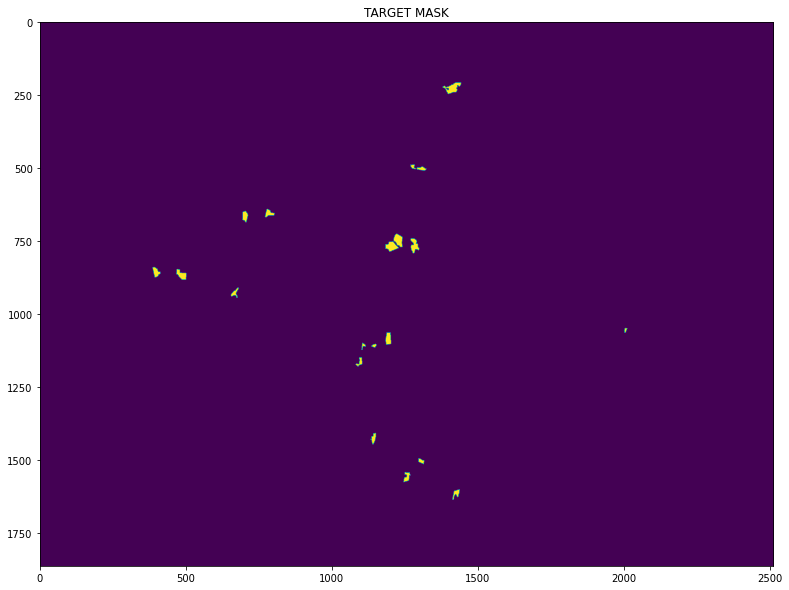

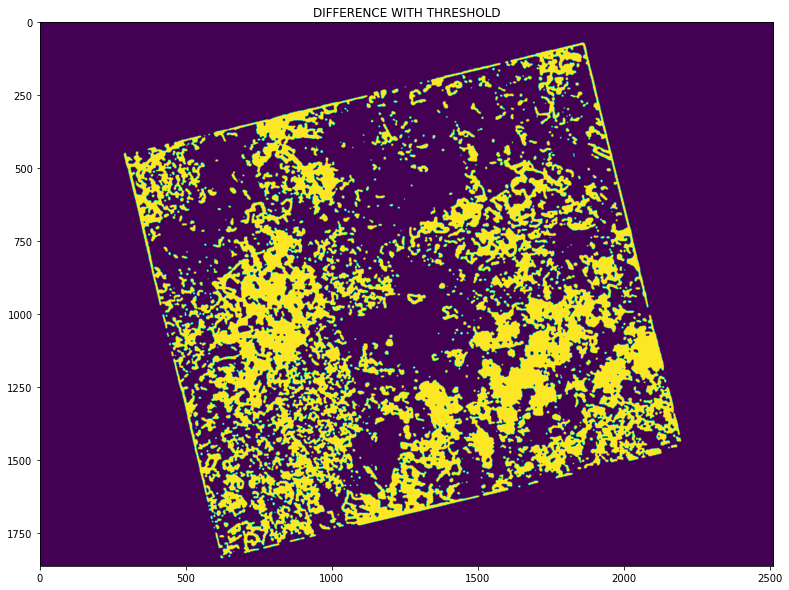

0it [00:18, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'write'

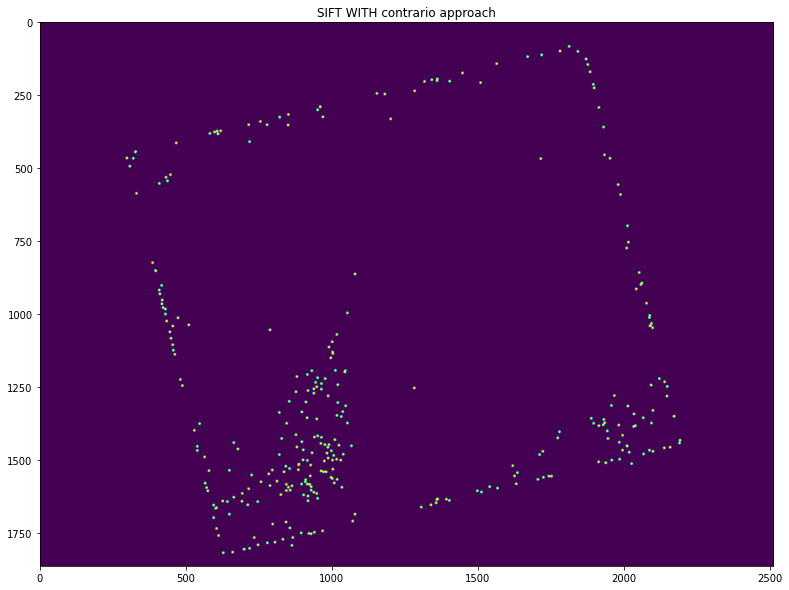

In [39]:
s = {}

for img1, img2, mask in tqdm(zip(all_photo1_val, all_photo2_val, masks_validation)):
    end1 = mask_final_dict(img1, img2, 5, 1e-5)
# Compute SSIM between two images
    (score, diff) = ssim(img1, img2, full=True)
    print("SSIM: {}".format(score))
    target = rasterio.open(mask).read(1)
    print(diff.max(), diff.min(), diff.dtype)
    kernel = np.ones((2, 2), 'uint8')
    diff[abs(diff) >= 0.99] = 1 
    diff = 1 - diff
    diff = diff - np.min(diff)
    diff = diff / np.max(diff)
    print(diff.max(), diff.min())
    kernel2 = np.ones((3, 3), 'uint8')
#     end = cv.erode(end1, kernel2,iterations = 6)
#     end = cv.dilate(end1, kernel2, iterations = 5)
    #end = cv.GaussianBlur(end,(5,5), 6)
    def porog(diff, low, up):
        maxd = np.max(diff)
        diff[diff<low*maxd] = 0
        diff[diff>up*maxd] = 0
#         print(len(diff[diff != 0]))
#         print(0.14*diff.shape[0]*diff.shape[1])
        if len(diff[diff != 0]) > np.round(0.15*diff.shape[0]*diff.shape[1]):
            maxd = np.max(diff)
            diff[diff<low*maxd] = 0
            diff[diff>up*maxd] = 0
        else:
            return diff
        
    diff = porog(diff, 0.29, 0.51)   

        
    diff[diff != 0] = 1
    diff = np.round(diff).astype(np.uint8)
    diff = cv.GaussianBlur(diff,(5,5), 5)
#     diff = cv.GaussianBlur(diff,(5,5), 5)
    diff = cv.GaussianBlur(diff,(5,5), 6)

    
    
    diff = cv.dilate(diff, kernel, iterations=4)
    diff = cv.GaussianBlur(diff,(5,5), 5)

    diff = cv.erode(diff, kernel,iterations = 1)
    plt.title('TARGET MASK')
    plt.imshow(target)
    plt.show()
    plt.title('DIFFERENCE WITH THRESHOLD')
    plt.imshow(diff)
    plt.show()
    s[mask.split('/')[-1].split('.')[0]] = decode_mask(diff)
    data = pd.DataFrame.from_dict(s, orient='index').reset_index()
    data.columns = ['Id','mask']
    data.to_csv("submission5.csv",index=False)
    plt.title('SIFT WITH contrario approach')
    plt.imshow(end1)
    plt.savefig(end1)
    plt.show()


In [ ]:
if __name__ == "__main__":
    
    
    parser = argparse.ArgumentParser()
    parser.add_argument('--radius', dest='radius', type=int, help = 'Радиус окрестности ключевой точки')
    parser.add_argument('--eps', dest='eps', type=str, help = 'Трешхолд для количества ложных тревог (N F A)')
    parser.add_argument('path2data', dest='path2data', type=int, help = 'Путь к данным')
    args = parser.parse_args()
    
    